<a href="https://colab.research.google.com/github/bibekebib/Major-project-raw-files/blob/main/First_CNN_model_from_scratch_for_all_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_path = '/content/drive/MyDrive/dataset'

In [ ]:
from glob import glob
import pandas as pd
import cv2 as cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/dataset/newdf_image_path.csv')

In [ ]:
lbe = LabelEncoder()

In [ ]:
df.head()

,Unnamed: 0,path,label
0,1992,/content/drive/MyDrive/NewDataset/brikshasana/...,brikshasana
1,939,/content/drive/MyDrive/NewDataset/trikonasana/...,trikonasana
2,1188,/content/drive/MyDrive/NewDataset/trikonasana/...,trikonasana
3,253,/content/drive/MyDrive/NewDataset/cat_cow/ cat...,cat_cow
4,1690,/content/drive/MyDrive/NewDataset/brikshasana/...,brikshasana


In [ ]:
df.label = lbe.fit_transform(df.label)

In [ ]:
df.head()

,Unnamed: 0,path,label
0,1992,/content/drive/MyDrive/NewDataset/brikshasana/...,0
1,939,/content/drive/MyDrive/NewDataset/trikonasana/...,2
2,1188,/content/drive/MyDrive/NewDataset/trikonasana/...,2
3,253,/content/drive/MyDrive/NewDataset/cat_cow/ cat...,1
4,1690,/content/drive/MyDrive/NewDataset/brikshasana/...,0


In [ ]:
df = df.sample(frac=1)

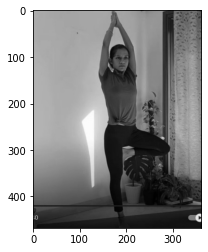

In [ ]:
plt.imshow(cv2.imread('/content/drive/MyDrive/NewDataset/brikshasana/ brikshasana-2_01 frame108.jpg'))

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, df, transforms=False):  
    self.imgpath = df.path 
    self.label = df.label
    # self.transforms = torchvision.transforms.Compose([
    #     torchvision.transforms.ToTensor(),
    #     torchvision.transforms.ToPILImage(),
    #     # torchvision.transforms.ToTensor(),
    #     # torchvision.transforms.functional.crop(100,100, 324,324)
    # ])
    self.transforms = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.ToPILImage(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Resize(224)
        # torchvision.transforms.functional.crop(100,100, 324,324)
    ])

  def __len__(self):
    return len(self.imgpath)
  
  def __getitem__(self, ix):
    f = self.imgpath[ix]
    target = (self.label[ix])
    im = cv2.imread(f)
    im = cv2.resize(im, (224,224))
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
    im = self.transforms(im)
    return torch.tensor(im).to(device).float(), torch.tensor(target).long().to(device)
 


In [ ]:
data = CustomDataset(df)

In [ ]:
im, label = data[600]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
print(im.shape)

torch.Size([1, 224, 224])


tensor(0, device='cuda:0')
torch.Size([1, 224, 224])


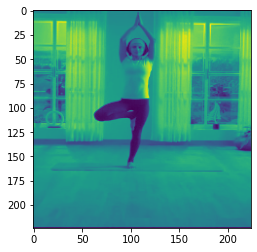

In [ ]:
plt.imshow(im.reshape(224,224).detach().cpu())
print(label)
print(im.shape)

In [ ]:
import torch.nn as nn

def conv_layer(ni, no, kernel_size, stride=1):
  return nn.Sequential(
      nn.Conv2d(ni, no, kernel_size, stride),
      nn.ReLU(),
      nn.BatchNorm2d(no),
      nn.MaxPool2d(2)
  )

In [ ]:
def get_model():
  model = nn.Sequential(
      conv_layer(1,16,3),
      conv_layer(16,64, 3),
      conv_layer(64, 256, 2),
      conv_layer(256, 512,2),
      conv_layer(512,512,2),
      nn.Flatten(),
      nn.Linear(512*25,1000),
      nn.ReLU(),
      nn.Linear(1000, 192),
      nn.ReLU(),
      nn.Linear(192, 3),
      nn.Softmax()
  ).to(device)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  return model, loss_fn, optimizer

In [ ]:
def calculateHWOUT(H_in, W_IN, padding, kernel_size, stride, max_pool_num):
    H_out = (((H_in + 2*padding - kernel_size) / stride ) +1) / max_pool_num
    W_out = (((W_IN + 2*padding - kernel_size) / stride ) +1) / max_pool_num
    return (int(H_out), int(W_out))

In [ ]:
calculateHWOUT(H_in=12, W_IN=12, padding=0, kernel_size=2, stride=1, max_pool_num=2)

(5, 5)

In [ ]:

model, loss_fn, optimizer = get_model()
from torchsummary import summary
summary(model, (1, 224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 222, 222]             160
              ReLU-2         [-1, 16, 222, 222]               0
       BatchNorm2d-3         [-1, 16, 222, 222]              32
         MaxPool2d-4         [-1, 16, 111, 111]               0
            Conv2d-5         [-1, 64, 109, 109]           9,280
              ReLU-6         [-1, 64, 109, 109]               0
       BatchNorm2d-7         [-1, 64, 109, 109]             128
         MaxPool2d-8           [-1, 64, 54, 54]               0
            Conv2d-9          [-1, 256, 53, 53]          65,792
             ReLU-10          [-1, 256, 53, 53]               0
      BatchNorm2d-11          [-1, 256, 53, 53]             512
        MaxPool2d-12          [-1, 256, 26, 26]               0
           Conv2d-13          [-1, 512, 25, 25]         524,800
             ReLU-14          [-1, 512,

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [ ]:
def get_data():
  train = CustomDataset(df)
  trn_dl = DataLoader(train, batch_size=32,shuffle=True, drop_last=True)
  return trn_dl

In [ ]:
def train_batch(x, y, model, loss_fn, opt):
  model.train()
  prediction = model(x)
  batch_loss = loss_fn(prediction, y)
  batch_loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  return batch_loss.item()

In [ ]:
@torch.no_grad()
def accuracy(x, y, model):
  model.eval()
  pred = model(x)
  _, is_correct = torch.max(pred.data,1)
  acc_all = (is_correct==y).detach().cpu().numpy()
  return acc_all

In [ ]:
trn_ldr = get_data()
model, loss_fn, optimizer = get_model()

In [ ]:
model, loss_fn, optimizer

(Sequential(
   (0): Sequential(
     (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
     (1): ReLU()
     (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (1): Sequential(
     (0): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
     (1): ReLU()
     (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (2): Sequential(
     (0): Conv2d(64, 256, kernel_size=(2, 2), stride=(1, 1))
     (1): ReLU()
     (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (3): Sequential(
     (0): Conv2d(256, 512, kernel_size=(2, 2), stride=(1, 1))
     (1): ReLU()
     (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affi

In [ ]:
# train_losses, train_accuracies = [], []
# val_losses, val_accuracies = [], []
# for epoch in range(5):
    
#     print(epoch)
#     train_epoch_losses, train_epoch_accuracies = [], []
#     val_epoch_accuracies = []
#     for ix, batch in enumerate(iter(trn_dl)):
#         #print(ix)
#         x, y = batch
#         x = x.reshape(32,1, 224,224)
  
#         batch_loss = train_batch(x, y, model, optimizer, loss_fn)
#         train_epoch_losses.append(batch_loss)        
#     train_epoch_loss = np.array(train_epoch_losses).mean()

#     for ix, batch in enumerate(iter(trn_dl)):
#         x, y = batch
#         x = x.reshape(32, 1, 224, 224)
#         is_correct = accuracy(x, y, model)
#         train_epoch_accuracies.extend(is_correct)
#     train_epoch_accuracy = np.mean(train_epoch_accuracies)



#     train_losses.append(train_epoch_loss)
#     train_accuracies.append(train_epoch_accuracy)
#     #val_losses.append(validation_loss)


In [ ]:
train_loss = []
train_accuracies= []
val_loss = [] 
val_accuracies = []

for i in range(10):
  print(f'Epoch: _________*****{i}*****_______')
  train_epoch_losses, train_epoch_accuracies = [], []
  val_epoch_accuracies, val_epoch_losses = [], []



  for ix, batch in (enumerate(iter(trn_ldr))):
      x, y = batch
      train_epoch_losses.append(train_batch(x, y, model, loss_fn, optimizer))
  train_epoch_loss = np.array(train_epoch_losses).mean()
  print(f'Epoch: _________*****{i} Training Loss : {train_epoch_loss} *****_______')



  for ix, batch in (enumerate(iter(trn_ldr))):
    x, y = batch
    train_epoch_accuracies.append(sum(accuracy(x, y, model)) / len(y))
  train_epoch_accuracy = np.array(train_epoch_accuracies).mean()
  print(f'Epoch: _________*****{i} Training Accuracy: {train_epoch_accuracy} *****_______')


  # for ix, batch in (enumerate(iter(test_ldr))):
  #   x, y = batch
  #   val_epoch_losses.append(val_loss_trn(x, y, model, loss_fn))
  # val_epoch_loss = np.array(val_epoch_losses).mean()
  # print(f'Epoch: _________*****{i} Validation Loss : {val_epoch_loss} *****_______')

  # for ix, batch in (enumerate(iter(test_ldr))):
  #   x, y = batch
  #   val_epoch_accuracies.append(sum(accuracy(x, y, model)) / len(y))
  # print(f'Epoch: _________*****{i} Validation Accuracy. {val_epoch_accuracy} *****_______')
  # val_epoch_accuracy = np.array(val_epoch_accuracies).mean()
  # print('\n')

  train_loss.append(train_epoch_loss)
  train_accuracies.append(train_epoch_accuracy)
  # val_accuracies.append(val_epoch_accuracy)
  # val_loss.append(val_epoch_loss)

Epoch: _________*****0*****_______


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: _________*****0 Training Loss : 0.7391021403055342 *****_______
Epoch: _________*****0 Training Accuracy: 0.7405753968253969 *****_______
Epoch: _________*****1*****_______
Epoch: _________*****1 Training Loss : 0.6313400136099921 *****_______
Epoch: _________*****1 Training Accuracy: 0.9221230158730159 *****_______
Epoch: _________*****2*****_______
Epoch: _________*****2 Training Loss : 0.6293221409358676 *****_______
Epoch: _________*****2 Training Accuracy: 0.9226190476190477 *****_______
Epoch: _________*****3*****_______
Epoch: _________*****3 Training Loss : 0.9566683409705995 *****_______
Epoch: _________*****3 Training Accuracy: 0.3948412698412698 *****_______
Epoch: _________*****4*****_______
Epoch: _________*****4 Training Loss : 1.0896393429665339 *****_______
Epoch: _________*****4 Training Accuracy: 0.4712301587301587 *****_______
Epoch: _________*****5*****_______
Epoch: _________*****5 Training Loss : 1.0871331001084947 *****_______
Epoch: _________*****5 Traini

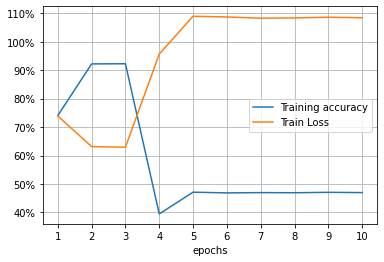

In [ ]:
epochs = np.arange(10) + 1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(epochs, train_accuracies , label='Training accuracy')
plt.plot(epochs, train_loss, label='Train Loss')
plt.gca().xaxis.set_major_locator(mtick.MultipleLocator(1))

plt.xlabel('epochs')

plt.legend()
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.grid('off')
plt.show()